In [1]:
import scanpy as sc
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
import umap

2025-12-13 06:21:56.182925: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-13 06:21:56.197510: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-13 06:21:56.197530: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-13 06:21:56.208113: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-13 06:21:56.819229: W tensorflow/compiler/tf

In [3]:
adata_structured = sc.read_h5ad('adata_latent_full.h5ad')
adata_cat = sc.read_h5ad('adata_structured_balanced_count.h5ad')
adata_org = sc.read_h5ad('/data/Experiments/Benchmark/SCDISENTANGLE_REPRODUCE/Datasets/preprocessed_datasets/seurat.h5ad')
adata_cat.var_names = adata_org.var_names.copy()

/home/SE/miniconda3/envs/trials/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/SE/miniconda3/envs/trials/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [4]:
# UMAP on last level
umap_model = umap.UMAP(n_components=2, random_state=1)

umap_model.fit(adata_structured.obsm['map_latent_summed'][adata_structured.obs['level'] == 15])

/home/SE/miniconda3/envs/trials/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/SE/miniconda3/envs/trials/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


,n_neighbors,15
,n_components,2
,metric,'euclidean'
,metric_kwds,None
,output_metric,'euclidean'
,output_metric_kwds,None
,n_epochs,None
,learning_rate,1.0
,init,'spectral'
,min_dist,0.1
,spread,1.0


In [5]:
# Infer on all other levels
X_umap = umap_model.transform(adata_cat.obsm['map_latent_summed'])

# Store the result in adata_cat
adata_cat.obsm['X_umap_fit'] = X_umap

<Axes: title={'center': 'celltype.l1'}, xlabel='X_umap_fit1', ylabel='X_umap_fit2'>

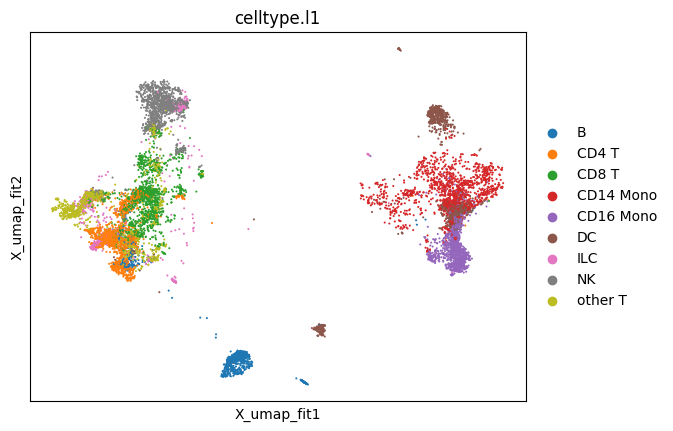

In [7]:
sc.pl.embedding(
    adata_cat,
    basis='X_umap_fit',
    color='celltype.l1',
    show=False
)

<Axes: title={'center': 'level'}, xlabel='X_umap_fit1', ylabel='X_umap_fit2'>

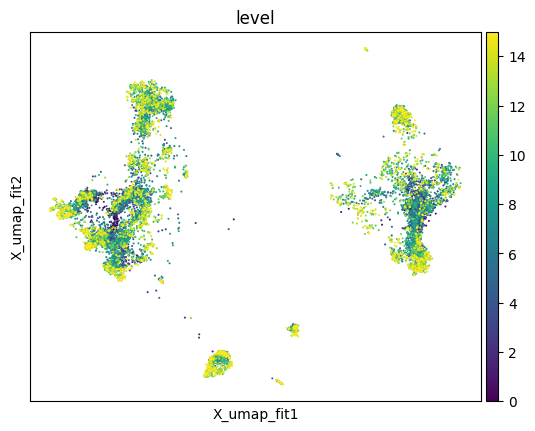

In [8]:
sc.pl.embedding(
    adata_cat,
    basis='X_umap_fit',
    color='level',
    show=False
)

In [9]:
def get_top_degs(adata, cell_type, ctype_key='cell_type', n_genes=10):
    # Make sure cell_type is categorical
    adata.obs[ctype_key] = adata.obs[ctype_key].astype('category')
    
    # Create binary column for the cell type of interest
    adata.obs['is_cell_type'] = (adata.obs[ctype_key] == cell_type).astype('category')
    
    # Perform rank genes groups test
    sc.tl.rank_genes_groups(adata, 
                           groupby='is_cell_type',
                           reference='rest',  # Compare against all other cells
                           method='wilcoxon',  # Using Wilcoxon rank-sum test
                           n_genes=n_genes,
                           use_raw=False
                           )
    
    # Get results
    top_genes = pd.DataFrame(
        {
            'genes': adata.uns['rank_genes_groups']['names']['True'],
            'scores': adata.uns['rank_genes_groups']['scores']['True'],
            'logfoldchanges': adata.uns['rank_genes_groups']['logfoldchanges']['True'],
            'pvals_adj': adata.uns['rank_genes_groups']['pvals_adj']['True']
        }
    )
    
    # Sort by absolute log fold change to get both up and down regulated genes
    top_genes['abs_logfc'] = abs(top_genes['logfoldchanges'])
    top_genes = top_genes.sort_values('abs_logfc', ascending=False)
    
    return top_genes

In [10]:
def plot_lfg_heatmap(adata, gene_name, cell_types, obs_col, save_name):
    # Filter and prepare
    adata_filtered = adata[adata.obs['cell_type'].isin(cell_types), :]
    df = adata_filtered.obs.groupby(['cell_type', 'level'])[obs_col].first().reset_index()
    df['level'] = df['level'].astype(int)

    # Pivot to matrix
    heatmap_data = df.pivot(index='cell_type', columns='level', values=obs_col)
    heatmap_data = heatmap_data.loc[cell_types]
    heatmap_data = heatmap_data.reindex(sorted(heatmap_data.columns), axis=1)

    # Auto-detect range and choose colormap
    vmin = heatmap_data.min().min()
    vmax = heatmap_data.max().max()
    
    if vmin < 0 and vmax > 0:
        # Symmetric diverging: blue → white → red
        cmap = LinearSegmentedColormap.from_list("blue_white_red", ["#2166ac", "#ffffff", "#b2182b"])
        center = 0
    else:
        # Sequential: white → red
        cmap = LinearSegmentedColormap.from_list("white_red", ["#ffffff", "#d73027"])
        center = None  # no center for sequential map

    # Size
    n_levels = heatmap_data.shape[1]
    n_cell_types = heatmap_data.shape[0]
    cell_size = 0.5
    figsize = (n_levels * cell_size, n_cell_types * cell_size)

    # Plot
    fig, ax = plt.subplots(figsize=figsize)

    sns.heatmap(
        heatmap_data,
        ax=ax,
        cmap=cmap,
        center=center,
        square=True,
        cbar=True,
        linewidths=0.5,
        linecolor='lightgray',
        annot=False,
        fmt='',
        cbar_kws={'label': f'{gene_name} LFG', 'shrink': 0.5}
    )

    # Aesthetics
    ax.set_xlabel("Latent level", fontsize=7, labelpad=6)
    ax.set_ylabel("Cell type", fontsize=7)
    ax.tick_params(axis='x', labelsize=6, rotation=0)
    ax.tick_params(axis='y', labelsize=6, rotation=0)
    plt.xticks(ticks=[i + 0.5 for i in range(n_levels)], labels=heatmap_data.columns)
    plt.yticks(ticks=[i + 0.5 for i in range(n_cell_types)], labels=heatmap_data.index)
    sns.despine(left=True, bottom=True)

    plt.tight_layout()
    if save_name:
        plt.savefig(f'{save_path}/{save_name}', dpi=600)
    plt.show()

In [11]:
def get_gene_score(
    adata,
    gene_to_use,
    cell_types,
    normalize=False
    ):

    #adata_copy = adata.copy()
    adata.obs[gene_to_use+'_score'] = None
    adata.obs[gene_to_use+'_lfg'] = None
    adata.obs[gene_to_use+'_exp'] = None
    for ctype in cell_types:
        
        for _lvl in np.unique(adata.obs['level']):
            ad = adata[adata.obs['level'] == _lvl][:, gene_to_use]
            _degs = get_top_degs(ad, cell_type=ctype, n_genes=20000)
            subset = _degs[_degs['genes'] == gene_to_use]
            score = subset['scores'].item()
            lfg = subset['logfoldchanges'].item()
            exp = ad[ad.obs['cell_type'] == ctype].X.mean()
            
            adata.obs[gene_to_use + '_score'][(adata.obs['level'] == _lvl) & (adata.obs['cell_type'] == ctype)] = score
            adata.obs[gene_to_use + '_lfg'][(adata.obs['level'] == _lvl) & (adata.obs['cell_type'] == ctype)] = lfg
            adata.obs[gene_to_use+'_exp'][(adata.obs['level'] == _lvl) & (adata.obs['cell_type'] == ctype)] = exp
            #adata_cat.obs[gene_to_use + '_lfg'][(adata_cat.obs['cell_type'] == ctype)] =  adata_cat.obs[gene_to_use + '_lfg'][(adata_cat.obs['cell_type'] == ctype)] / adata_cat.obs[gene_to_use + '_lfg'][(adata_cat.obs['cell_type'] == ctype)].max()

        if normalize:
            vals = adata.obs[gene_to_use + '_score'][(adata.obs['cell_type'] == ctype)]
            normalized_vals = (vals - vals.min()) / (vals.max() - vals.min())
            adata.obs.loc[(adata.obs['cell_type'] == ctype), gene_to_use + '_score'] = normalized_vals

            vals = adata.obs[gene_to_use + '_lfg'][(adata.obs['cell_type'] == ctype)]
            normalized_vals = (vals - vals.min()) / (vals.max() - vals.min())
            adata.obs.loc[(adata.obs['cell_type'] == ctype), gene_to_use + '_lfg'] = normalized_vals

        adata.obs[gene_to_use+'_lfg'] = adata.obs[gene_to_use+'_lfg'].astype(float)
        adata.obs[gene_to_use+'_score'] = adata.obs[gene_to_use+'_score'].astype(float)
        adata.obs[gene_to_use+'_exp'] = adata.obs[gene_to_use+'_exp'].astype(float)
    return adata

In [12]:
def normalize_by_cell_type(adata, gene_to_use, cell_types):
    """
    Normalize the expression of a gene by its value within each cell type,
    such that the mean becomes 0 and the standard deviation becomes 1.

    Parameters:
    ----------
    adata : AnnData
        AnnData object containing gene expression data.
    gene_to_use : str
        Gene to normalize.
    cell_types : list of str
        List of cell types to loop over.

    Returns:
    --------
    adata : AnnData
        AnnData object with normalized gene expression in obs.
    """
    for cell_type in cell_types:
        mask = adata.obs['cell_type'] == cell_type
        gene_values = adata.obs.loc[mask, gene_to_use]
        mean_value = gene_values.mean()
        std_value = gene_values.std()

        if std_value != 0:
            adata.obs.loc[mask, f"{gene_to_use}_normalized"] = (gene_values - mean_value) / std_value
        else:
            adata.obs.loc[mask, f"{gene_to_use}_normalized"] = 0

    return adata

In [13]:
adata_cat.obsm['X_umap'] = adata_cat.obsm['X_umap_fit'].copy()

In [15]:
adata_cat.obs['cell_type'] = adata_cat.obs['celltype.l1']

In [17]:
adata_cat.obs['cell_type']

L1_AAGAACAGTAGTGTGG             NK
L1_AATAGAGAGTGATCGG              B
L1_ACATGCAAGTCTGTAC          CD8 T
L1_ACCCAAACAATCCAGT      CD16 Mono
L1_ACGGTCGTCACCGACG             NK
                           ...    
E2L8_TGTCCACTCCAAGCCG        CD4 T
E2L8_TTAATCCGTCTTCTAT      other T
E2L8_TTGAACGAGTTGGCGA           DC
E2L8_TTGTTCAAGTCCTACA           DC
E2L8_TTTGGTTCATAATGCC           DC
Name: cell_type, Length: 13680, dtype: category
Categories (9, object): ['B', 'CD4 T', 'CD8 T', 'CD14 Mono', ..., 'DC', 'ILC', 'NK', 'other T']

/tmp/ipykernel_968201/2724619591.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[ctype_key] = adata.obs[ctype_key].astype('category')
/tmp/ipykernel_968201/2866244741.py:22: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

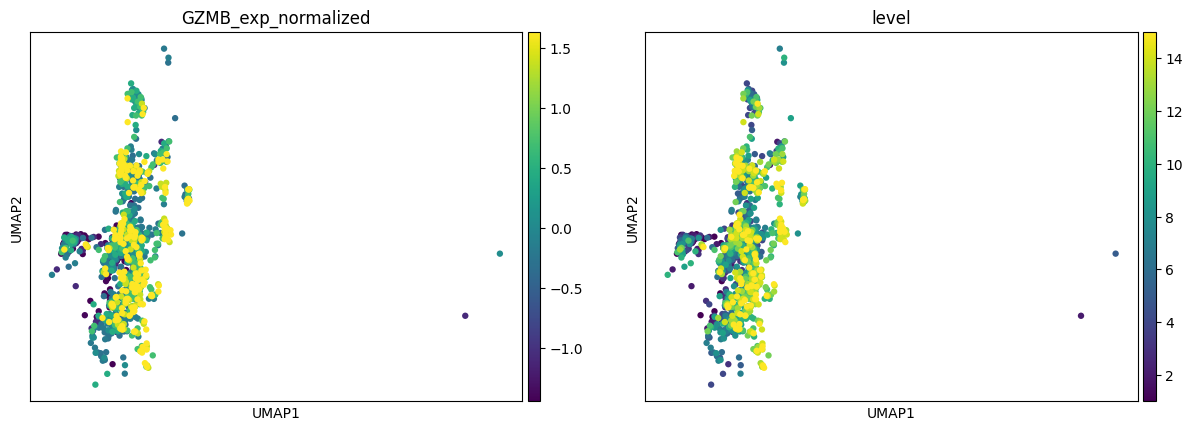

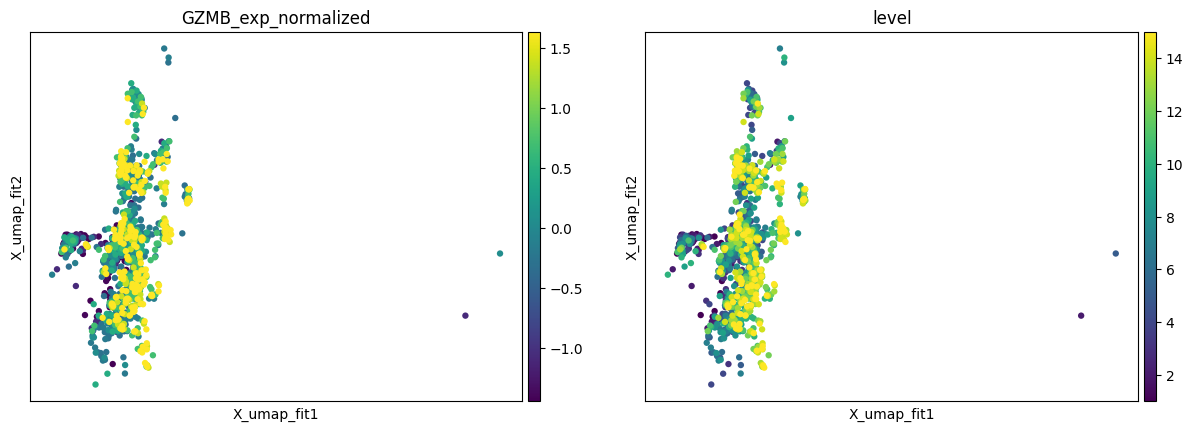

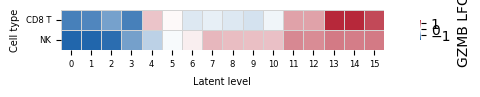

/tmp/ipykernel_968201/2017484464.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = adata_filtered.obs.groupby(['cell_type', 'level'])[obs_col].first().reset_index()


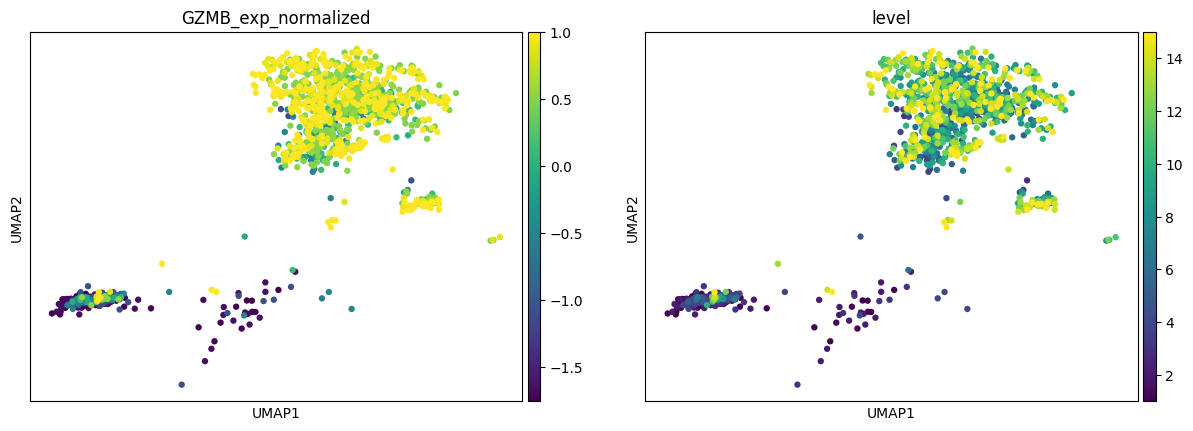

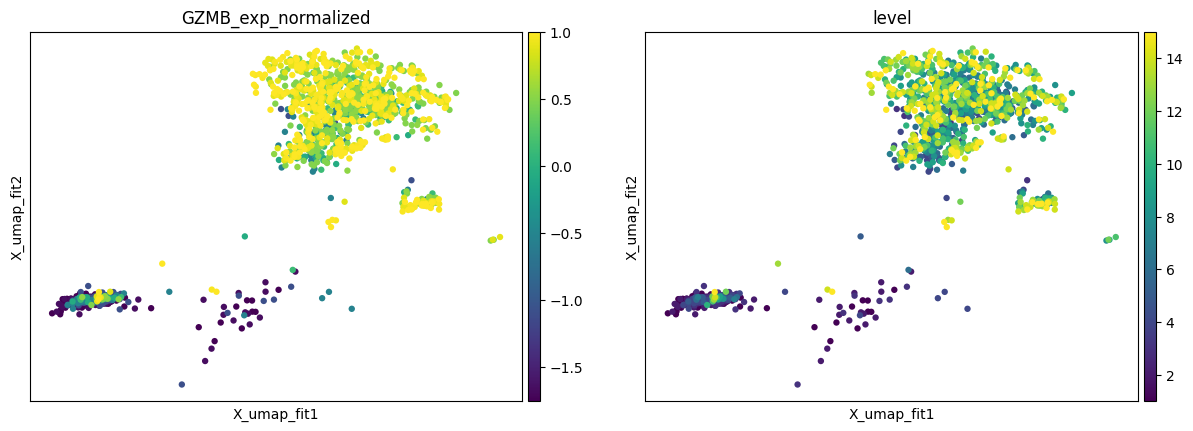

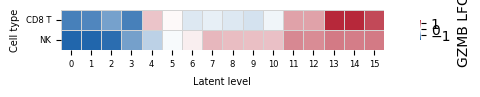

In [19]:
subset_ctypes = ['CD8 T', 'NK']
gene_to_use = 'GZMB'
cell_types = adata_cat.obs['cell_type'].unique().tolist()
adata_cat = get_gene_score(
    adata=adata_cat,
    gene_to_use=gene_to_use,
    cell_types=cell_types,
    normalize=False
)

adata_cat = normalize_by_cell_type(adata_cat, gene_to_use + '_exp', cell_types)



# lfg_path = save_path + '/LFGs'
# if not os.path.exists(lfg_path):
#     os.makedirs(lfg_path)
lfg_path = '/data/scDisentangle figures/Seurat'
save_path = lfg_path
    
for ctype in subset_ctypes:
    
    adata_subset = adata_cat[(adata_cat.obs['cell_type'] == ctype) & (adata_cat.obs['level']!=0)]
    sc.pl.umap(adata_subset, color=[f'{gene_to_use}_exp_normalized', 'level'], show=False)
    plt.savefig(f'{lfg_path}/{gene_to_use}_{ctype}_lfg_umap.png', dpi=500, bbox_inches='tight')
    sc.pl.embedding(adata_subset, basis='X_umap_fit', color=[f'{gene_to_use}_exp_normalized', 'level'], show=False)
    plt.savefig(f'{lfg_path}/{gene_to_use}_{ctype}_lfg_umap_fit.png', dpi=500, bbox_inches='tight')
    plot_lfg_heatmap(adata_cat, gene_name=gene_to_use, cell_types=subset_ctypes, obs_col=f'{gene_to_use}_exp_normalized', save_name=f'{gene_to_use}_{ctype}.png')

In [ ]:
sc.pp.normalize_total(adata_cat)
sc.pp.log1p(adata_cat)

/tmp/ipykernel_968201/2724619591.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[ctype_key] = adata.obs[ctype_key].astype('category')
/tmp/ipykernel_968201/2866244741.py:22: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

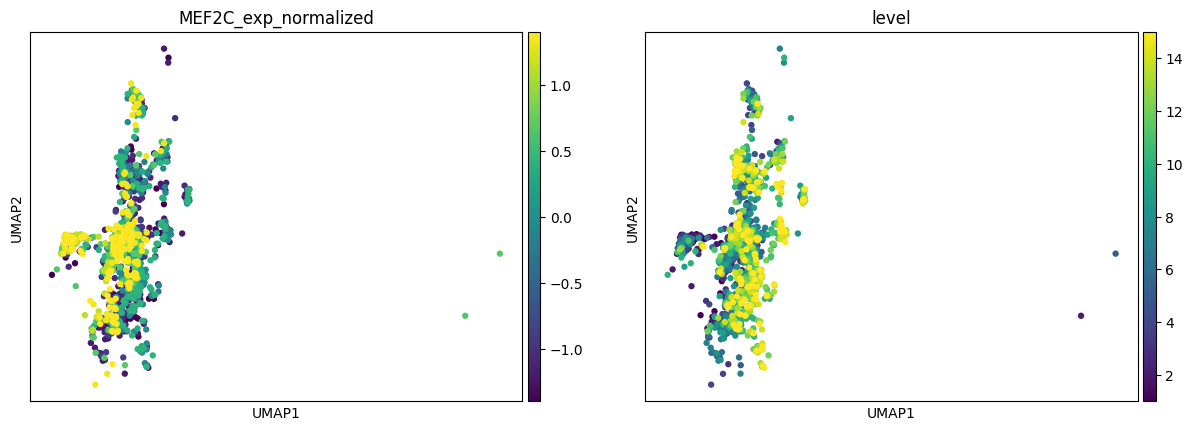

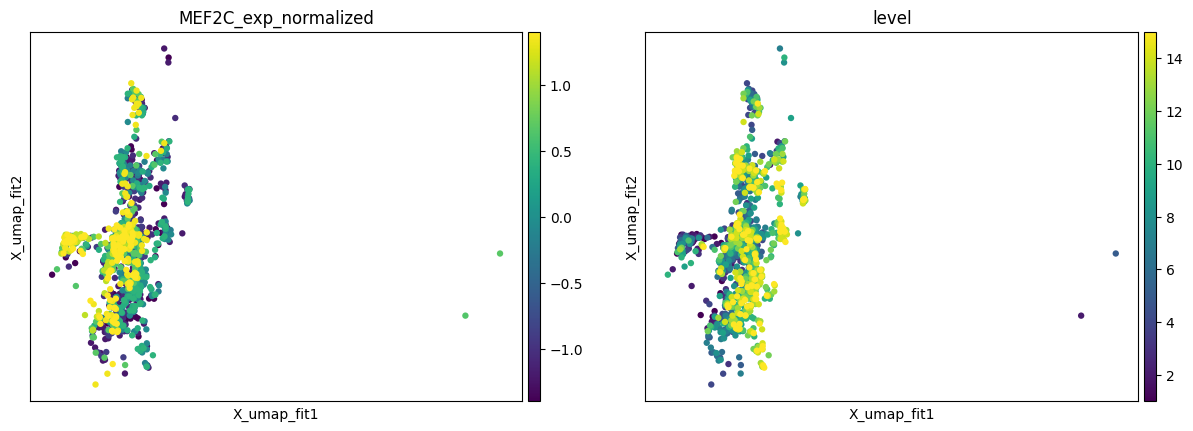

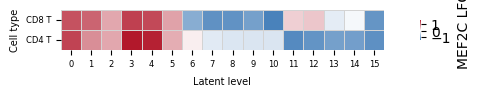

/tmp/ipykernel_968201/2017484464.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = adata_filtered.obs.groupby(['cell_type', 'level'])[obs_col].first().reset_index()


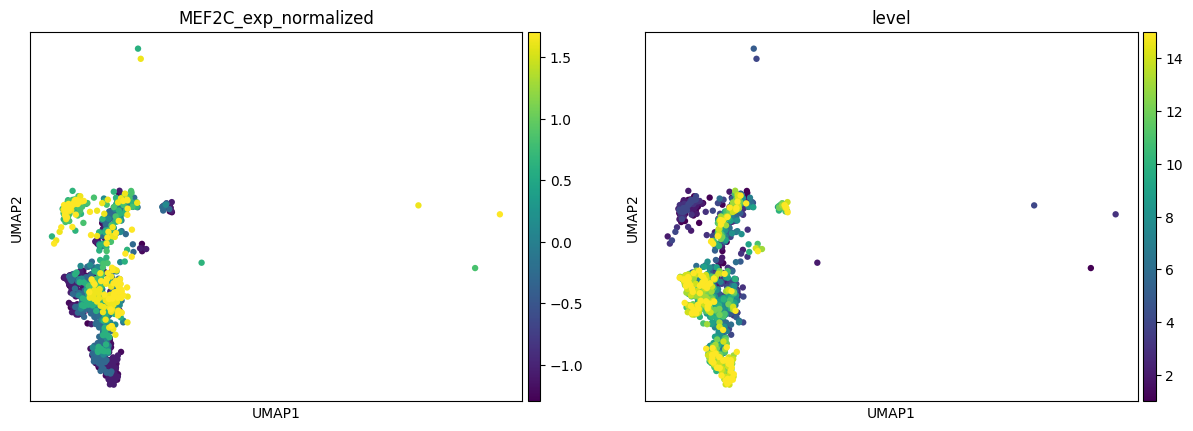

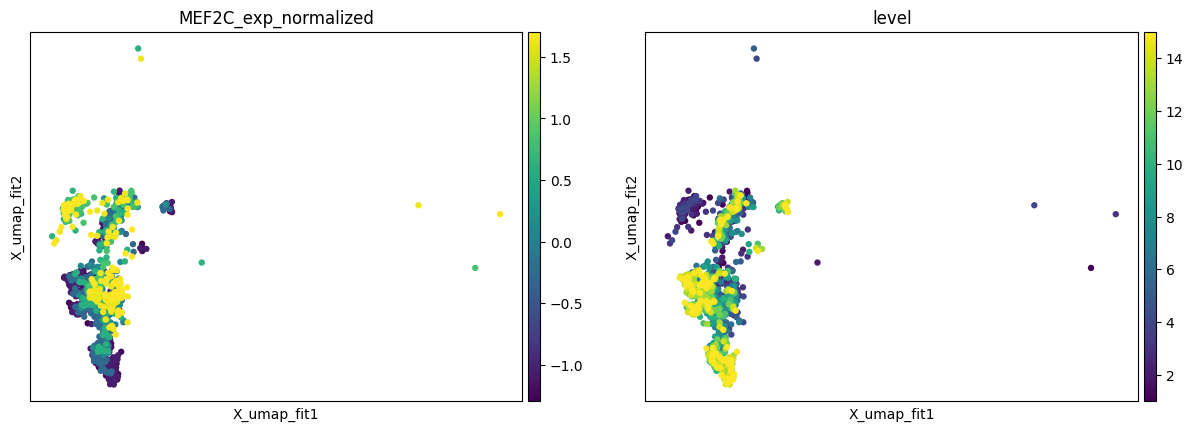

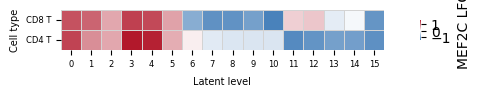

In [22]:
subset_ctypes = ['CD8 T', 'CD4 T']
gene_to_use = 'MEF2C'
cell_types = adata_cat.obs['cell_type'].unique().tolist()
adata_cat = get_gene_score(
    adata=adata_cat,
    gene_to_use=gene_to_use,
    cell_types=cell_types,
    normalize=False
)

adata_cat = normalize_by_cell_type(adata_cat, gene_to_use+'_exp', cell_types)
 
lfg_path = '/data/scDisentangle figures/Seurat_temp'

lfg_path = save_path + '/LFGs'
if not os.path.exists(lfg_path):
    os.makedirs(lfg_path)

save_path = lfg_path
    
for ctype in subset_ctypes:
    
    adata_subset = adata_cat[(adata_cat.obs['cell_type'] == ctype) & (adata_cat.obs['level']!=0)]
    sc.pl.umap(adata_subset, color=[f'{gene_to_use}_exp_normalized', 'level'], show=False)
    plt.savefig(f'{lfg_path}/{gene_to_use}_{ctype}_lfg_umap.png', dpi=500, bbox_inches='tight')
    sc.pl.embedding(adata_subset, basis='X_umap_fit', color=[f'{gene_to_use}_exp_normalized', 'level'], show=False)
    plt.savefig(f'{lfg_path}/{gene_to_use}_{ctype}_lfg_umap_fit.png', dpi=500, bbox_inches='tight')
    plot_lfg_heatmap(adata_cat, gene_name=gene_to_use, cell_types=subset_ctypes, obs_col=f'{gene_to_use}_exp_normalized', save_name=f'{gene_to_use}_{ctype}.png')